In [1]:
import pandas as pd

temp_list = []

with open("train_call.txt", 'r') as temp:
    for line in temp:
        temp_list.append(line.split())

columns_temp = temp_list[0]
columns_temp = [x.replace("\"", "") for x in columns_temp]

df_train = pd.DataFrame(temp_list[1:], columns=columns_temp)
X = df_train.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
X = X.transpose()

labels = []

# X for features Y for breast cancer subtype where 1 = HER2+, 2 = HR+, 3 = Triple Neg
with open("Train_clinical.txt", 'r') as temp_labels:
    next(temp_labels)
    for line in temp_labels:
        temp = line.strip()
        temp = temp.split()
        if temp[1].strip("\"") == "HER2+":
            labels.append(1)
        if temp[1].strip("\"") == "HR+":
            labels.append(2)
        if temp[1].strip("\"") == "Triple":
            labels.append(3)

Y = labels
            
important_genes = []

with open("important_genes_2.csv", 'r') as imp_genes:
    for line in imp_genes:
        temp = line.strip()
        important_genes.append(temp.split(","))
        
imp_genes = []

for gene in important_genes[1:]:
    imp_genes.append([gene[0], gene[1], gene[2], gene[3]])
    
important_genes = []

for x in imp_genes:
    for i, y in enumerate(df_train.values.tolist()):
        if x[1] == y[0] and x[2] == y[1] and x[3] == y[2]:
            important_genes.append(i)
            
print(X)
print(Y)
print("The regions found in the literature were: ", important_genes)

          0    1    2    3    4    5    6    7    8    9     ... 2824 2825  \
Array.129    0    0    0    0    0    0    0    0    0    0  ...    2    2   
Array.34     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.67     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.24     0    0    0    0    0    0    0   -1    0    0  ...    0    0   
Array.22     0    0    0    0    0    0    0    0    0    0  ...    1    1   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Array.10     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.123    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.100    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.134   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...    1    1   
Array.130    0    0    0    0    0    0    0    0    0    0  ...    1    1   

          2826 2827 2828 2829 2830 2831 2832 2833  
Array.129  

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# #Loading data
patients = X.values.tolist()

## FEATURE SELECTION

# we need to shift the features by 1 since the chi2 function does not take non-negative values
patients_shift = []

for patient in patients:
    x = []
    for feature in patient:
        x.append(int(feature) + 1)
    patients_shift.append(x)

chi, p_val = chi2(patients_shift, Y)

imp_genes_p_values = []

for i, j in enumerate(important_genes):
    if p_val[j] >= 0.05:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "No"])
    else:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "Yes"])
    

important_genes_scores = pd.DataFrame(imp_genes_p_values, columns=["Gene", "Region number", "P-value", "Yes/No"])
pd.set_option('display.max_rows', 75)
print(important_genes_scores)

X_feature_selected = X

threshold = 0.05
for i, val in enumerate(p_val):
    # this drops the p_values higher than 0.05 that are not in the significant genes list
    if val >= threshold and i not in important_genes:
        X_feature_selected = X_feature_selected.drop([i], axis=1)

                 Gene  Region number       P-value Yes/No
0              DIRAS3            111  6.897062e-01     No
1              PTPN22            157  7.287985e-01     No
2                 AGT            249  9.791761e-01     No
3               CLSPN             65  5.039604e-01     No
4   BARD1/CASP8/CTLA4            361  8.022867e-01     No
5               SF3B1            360  8.717109e-01     No
6              PIK3CA            479  4.007464e-01     No
7               NFKB1            576  8.076397e-01     No
8                FGF2            583  8.076397e-01     No
9               RAD50            688  1.138701e-01     No
10             MAP3K1            664  1.569463e-01     No
11               TERT            625  9.757757e-01     No
12             PIK3R1            670  4.250528e-02    Yes
13              CCND3            772  1.568220e-01     No
14               ESR1            876  4.297669e-01     No
15               ESR1            877  3.435048e-01     No
16            

In [3]:
X = X_feature_selected
number_of_features = len(X.values.tolist()[0])
print("Number of features = {}".format(number_of_features))

Number of features = 204


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# def classification_report_with_accuracy_score(y_true, y_pred):
#     "Scorer for the cross validation function"
#     originalclass.extend(y_true)
#     predictedclass.extend(y_pred)
#     return accuracy_score(y_true, y_pred) 

# def evaluate_model(model, features, labels):
#     "Gets the cross validation score using a 5-fold (cv=5) cross validation"
#     scores = cross_val_score(model, features, labels, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))
#     return scores

In [5]:
def nested_cross_validation(MODEL, PARAMS, X, Y, NUM_TRIALS):
    model_scores = np.zeros(NUM_TRIALS)
    model_params = {}
    nested_scores = []
    
    for i in range(NUM_TRIALS):
        print("Running Trial {}...".format(i + 1))
        inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        
        model = GridSearchCV(estimator=MODEL, param_grid=PARAMS, cv=inner_cv, n_jobs=2)
        model.fit(X, Y)
        print(model.score(X, Y), model.best_params_)
        model_scores[i] = model.score(X, Y)
        model_params[i] = model.best_params_
        
        nested_score = cross_val_score(model, X=X, y=Y, cv=outer_cv)
        nested_scores.append([nested_score.mean(), nested_score.std()])
        print(nested_score.mean(), nested_score.std())
        
    return model_scores, model_params, nested_scores

In [6]:
parameters = {'solver': ['lbfgs'], 
              'max_iter': [500, 1000, 1500, 2000], 
              'hidden_layer_sizes':np.linspace(20, number_of_features, 4, dtype=int)
             }

mlp = MLPClassifier()

mlp_scores, mlp_params, mlp_nested = nested_cross_validation(mlp, parameters, X, Y, 100)

Running Trial 1...
1.0 {'hidden_layer_sizes': 20, 'max_iter': 500, 'solver': 'lbfgs'}
0.8300000000000001 0.11090536506409417
Running Trial 2...
1.0 {'hidden_layer_sizes': 142, 'max_iter': 1500, 'solver': 'lbfgs'}
0.87 0.033166247903554026
Running Trial 3...
1.0 {'hidden_layer_sizes': 142, 'max_iter': 1500, 'solver': 'lbfgs'}
0.88 0.040000000000000036
Running Trial 4...
1.0 {'hidden_layer_sizes': 20, 'max_iter': 1000, 'solver': 'lbfgs'}
0.8 0.028284271247461888
Running Trial 5...
1.0 {'hidden_layer_sizes': 81, 'max_iter': 1000, 'solver': 'lbfgs'}
0.8699999999999999 0.05916079783099614
Running Trial 6...
1.0 {'hidden_layer_sizes': 204, 'max_iter': 1500, 'solver': 'lbfgs'}
0.8500000000000001 0.07141428428542851
Running Trial 7...
1.0 {'hidden_layer_sizes': 142, 'max_iter': 500, 'solver': 'lbfgs'}
0.83 0.11090536506409417
Running Trial 8...
1.0 {'hidden_layer_sizes': 142, 'max_iter': 1500, 'solver': 'lbfgs'}
0.8700000000000001 0.04358898943540673
Running Trial 9...
1.0 {'hidden_layer_sizes

1.0 {'hidden_layer_sizes': 81, 'max_iter': 2000, 'solver': 'lbfgs'}
0.86 0.03464101615137758
Running Trial 71...
1.0 {'hidden_layer_sizes': 81, 'max_iter': 1500, 'solver': 'lbfgs'}
0.87 0.033166247903554026
Running Trial 72...
1.0 {'hidden_layer_sizes': 204, 'max_iter': 1000, 'solver': 'lbfgs'}
0.8500000000000001 0.051961524227066305
Running Trial 73...
1.0 {'hidden_layer_sizes': 20, 'max_iter': 2000, 'solver': 'lbfgs'}
0.87 0.04358898943540673
Running Trial 74...
1.0 {'hidden_layer_sizes': 204, 'max_iter': 1000, 'solver': 'lbfgs'}
0.87 0.04358898943540673
Running Trial 75...
1.0 {'hidden_layer_sizes': 20, 'max_iter': 500, 'solver': 'lbfgs'}
0.8600000000000001 0.034641016151377525
Running Trial 76...
1.0 {'hidden_layer_sizes': 20, 'max_iter': 1500, 'solver': 'lbfgs'}
0.8699999999999999 0.05916079783099614
Running Trial 77...
1.0 {'hidden_layer_sizes': 142, 'max_iter': 500, 'solver': 'lbfgs'}
0.8300000000000001 0.04358898943540673
Running Trial 78...
1.0 {'hidden_layer_sizes': 20, 'max_

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5, dtype=int)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features}

rf = RandomForestClassifier()

rf_scores, rf_params, rf_nested = nested_cross_validation(rf, parameters, X, Y, 100)

Running Trial 1...
1.0 {'max_features': 'auto', 'n_estimators': 387}
0.76 0.028284271247461926
Running Trial 2...
1.0 {'max_features': 'sqrt', 'n_estimators': 162}
0.8200000000000001 0.06
Running Trial 3...
1.0 {'max_features': 'sqrt', 'n_estimators': 275}
0.8300000000000001 0.05196152422706631
Running Trial 4...
1.0 {'max_features': 'sqrt', 'n_estimators': 275}
0.7500000000000001 0.0714142842854285
Running Trial 5...
1.0 {'max_features': 'auto', 'n_estimators': 162}
0.76 0.08485281374238571
Running Trial 6...
1.0 {'max_features': 'sqrt', 'n_estimators': 162}
0.81 0.06557438524302002
Running Trial 7...
1.0 {'max_features': 'sqrt', 'n_estimators': 275}
0.7999999999999999 0.09380831519646858
Running Trial 8...
0.99 {'max_features': 'auto', 'n_estimators': 50}
0.82 0.09999999999999996
Running Trial 9...
1.0 {'max_features': 'auto', 'n_estimators': 162}
0.76 0.040000000000000036
Running Trial 10...
1.0 {'max_features': 'auto', 'n_estimators': 275}
0.81 0.11445523142259596
Running Trial 11.

1.0 {'max_features': 'sqrt', 'n_estimators': 275}
0.79 0.10344080432788601
Running Trial 86...
1.0 {'max_features': 'sqrt', 'n_estimators': 275}
0.79 0.07141428428542848
Running Trial 87...
1.0 {'max_features': 'auto', 'n_estimators': 275}
0.79 0.05196152422706631
Running Trial 88...
1.0 {'max_features': 'auto', 'n_estimators': 162}
0.76 0.04898979485566356
Running Trial 89...
1.0 {'max_features': 'auto', 'n_estimators': 275}
0.78 0.044721359549995794
Running Trial 90...
1.0 {'max_features': 'auto', 'n_estimators': 162}
0.82 0.10770329614269007
Running Trial 91...
1.0 {'max_features': 'sqrt', 'n_estimators': 50}
0.77 0.11445523142259599
Running Trial 92...
1.0 {'max_features': 'auto', 'n_estimators': 500}
0.81 0.051961524227066305
Running Trial 93...
1.0 {'max_features': 'auto', 'n_estimators': 50}
0.76 0.07999999999999996
Running Trial 94...
1.0 {'max_features': 'auto', 'n_estimators': 275}
0.73 0.11090536506409417
Running Trial 95...
1.0 {'max_features': 'sqrt', 'n_estimators': 275}


In [12]:
params = {
          "var_smoothing" : [1e-5, 1e-9]
}
nb = GaussianNB()

nb_scores, nb_params, nb_nested = nested_cross_validation(nb, params, X, Y, 100)

Running Trial 1...
0.89 {'var_smoothing': 1e-05}
0.81 0.0768114574786861
Running Trial 2...
0.89 {'var_smoothing': 1e-09}
0.8099999999999999 0.1072380529476361
Running Trial 3...
0.89 {'var_smoothing': 1e-09}
0.8 0.0692820323027551
Running Trial 4...
0.89 {'var_smoothing': 1e-05}
0.8 0.04898979485566356
Running Trial 5...
0.89 {'var_smoothing': 1e-09}
0.77 0.11445523142259599
Running Trial 6...
0.89 {'var_smoothing': 1e-05}
0.79 0.04358898943540674
Running Trial 7...
0.89 {'var_smoothing': 1e-05}
0.78 0.08717797887081347
Running Trial 8...
0.89 {'var_smoothing': 1e-05}
0.83 0.12449899597988731
Running Trial 9...
0.89 {'var_smoothing': 1e-05}
0.78 0.034641016151377525
Running Trial 10...
0.89 {'var_smoothing': 1e-05}
0.78 0.1
Running Trial 11...
0.89 {'var_smoothing': 1e-09}
0.81 0.11090536506409417
Running Trial 12...
0.89 {'var_smoothing': 1e-09}
0.8199999999999998 0.10392304845413264
Running Trial 13...
0.89 {'var_smoothing': 1e-09}
0.8300000000000001 0.08660254037844384
Running Tria

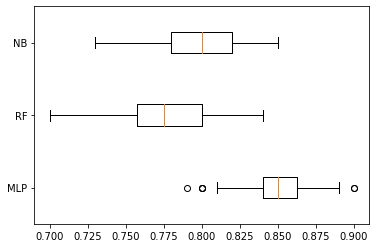

In [14]:
temp1 = np.array(mlp_nested)[:,0] 
temp2 = np.array(rf_nested)[:,0]
temp3 = np.array(nb_nested)[:,0]

# print(temp1)

plt.boxplot([temp1, temp2, temp3], vert=0, labels=['MLP', 'RF', "NB"])
plt.savefig("boxplot.png", dpi=300)
plt.show()

In [ ]:
# Random Forest

originalclass = []
predictedclass = []

random_forest = RandomForestClassifier(n_estimators=100)
temp = evaluate_model(random_forest, X, Y)
print(classification_report(originalclass, predictedclass)) 

In [ ]:
# Naive Bayes

originalclass = []
predictedclass = []

gnb = GaussianNB()
temp = evaluate_model(gnb, X, Y)
print(classification_report(originalclass, predictedclass))

In [ ]:
# Neural network with 1 hidden layer (the hidden layer is as big as the number of features)

originalclass = []
predictedclass = []

mlp = MLPClassifier(solver='lbfgs', activation="relu", alpha=0.0001,
                    hidden_layer_sizes=(135,), max_iter=1300)

temp = evaluate_model(mlp, X, Y)
print(classification_report(originalclass, predictedclass))

In [ ]:
# Neural network with 2 hidden layer (the hidden layer is as big as the number of features)

originalclass = []
predictedclass = []

mlp = MLPClassifier(solver='lbfgs', activation="relu", alpha=1e-5,
                    hidden_layer_sizes=(number_of_features, number_of_features), max_iter=1000)

temp = evaluate_model(mlp, X, Y)
print(classification_report(originalclass, predictedclass))

In [ ]:
# Neural network with 3 hidden layer (the hidden layer is as big as the number of features)

originalclass = []
predictedclass = []

mlp = MLPClassifier(solver='lbfgs', activation="relu", alpha=1e-5,
                    hidden_layer_sizes=(number_of_features, number_of_features, number_of_features,), max_iter=1000)

temp = evaluate_model(mlp, X, Y)
print(classification_report(originalclass, predictedclass))